In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import wikipedia as wp
import yfinance as yf
from ta.momentum import rsi
from ta.trend import macd

# Data collection and preprocessing
The first step of the project is to collect the S&P100 stocks and their historical values. The S&P100 is a stock market index made up of 100 major companies in the United States that are listed on the NYSE or NASDAQ. The index is a subset of the S&P 500 and is used as a benchmark for the US stock market.
The data is first collected then normalized.

## S&P100 stocks
The Wikipedia page is used to retrieve the S&P100 stocks list.
Notes:
- Alphabet Inc. (Google) is listed twice in the table due to the two different classes of shares. GOOGL is kept, as the oldest class of shares, and GOOG is deleted.
- Berkshire Hathaway is listed as BRK.B on wikipedia, while being listed as BRK-B on yahoo! finance. The symbol is changed in this list to the yfinance value.

In [2]:
html = wp.page("S&P 100").html().encode("UTF-8")
stocks = pd.read_html(html)[2].set_index("Symbol")
stocks = stocks.drop("GOOG")
stocks.loc["GOOGL", "Name"] = "Alphabet"
stocks = stocks.rename(index={"BRK.B": "BRK-B"})
stocks.head()

,Name,Sector
Symbol,,
AAPL,Apple,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe,Information Technology


## Fundamentals
The fundamentals of the stocks, such as market capitalization or P/E Ratio, are collected via yfinance. These values will be used to find similarities between stock to create the graph.

In [3]:
fundamentals = [
	yf.Ticker(stock).info for stock in stocks.index
]
fundamentals = pd.DataFrame(fundamentals).set_index("symbol")
fundamentals.index = fundamentals.index.rename("Symbol")  # for consistency with the stocks dataframe
fundamentals = fundamentals[["marketCap", "trailingPE", "forwardPE", "pegRatio", "priceToBook", "trailingEps", "forwardEps", "bookValue", "payoutRatio", "beta", "fiveYearAvgDividendYield", "52WeekChange", "averageVolume", "enterpriseToRevenue", "profitMargins"]].fillna(0)
fundamentals.head()

,marketCap,trailingPE,forwardPE,pegRatio,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,,
AAPL,2856436105216,28.970451,25.764868,2.53,38.511475,6.43,7.23,4.837,0.1493,1.264,0.73,0.082583,64714114,7.583,0.26306
ABBV,284799500288,48.143284,13.362055,2.34,35.563396,3.35,12.07,4.535,1.7827,0.593,4.40,0.125550,5682345,6.270,0.11016
ABT,182261022720,32.638626,20.383268,2.79,4.696311,3.21,5.14,22.309,0.6480,0.751,1.60,-0.042234,5704170,4.725,0.13961
ACN,193277591552,27.845110,23.430641,3.34,7.127191,11.04,13.12,43.132,0.4370,1.207,1.34,0.101078,2723860,2.976,0.10889
ADBE,216433278976,46.098280,23.716738,2.00,14.155826,10.48,20.37,34.128,0.0000,1.281,0.12,0.399873,3824416,10.719,0.24082


In [4]:
normalized_fundamentals = (fundamentals - fundamentals.mean()) / fundamentals.std()
normalized_fundamentals.head()

,marketCap,trailingPE,forwardPE,pegRatio,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,,
AAPL,4.756233,-0.076554,0.897750,0.239086,0.508115,-0.198375,-0.294428,-0.100833,-0.469904,0.725755,-0.958954,-0.479303,3.287058,0.532988,0.738303
ABBV,-0.069478,0.503670,-0.598612,0.179432,0.445301,-0.404313,-0.071446,-0.100840,1.189561,-1.026923,1.212553,-0.351215,-0.368369,0.285018,-0.401171
ABT,-0.261893,0.034455,0.248476,0.320717,-0.212373,-0.413674,-0.390716,-0.100393,0.036754,-0.614221,-0.444183,-0.851392,-0.367018,-0.006767,-0.181697
ACN,-0.241220,-0.110610,0.616133,0.493398,-0.160579,0.109862,-0.023072,-0.099869,-0.177613,0.576869,-0.598022,-0.424167,-0.551568,-0.337079,-0.410635
ADBE,-0.197768,0.441783,0.650650,0.072683,-0.010822,0.072419,0.310940,-0.100096,-0.621586,0.770160,-1.319886,0.466563,-0.483418,1.125246,0.572562


In [5]:
normalized_fundamentals.to_csv("../data/SP100/raw/fundamentals.csv")

## Historical values
The historical values of the stocks will be obtained using the yfinance library. The values for the last five years will be retrieved. Multi-level indexing is used to store the historical values for each stock, indexing by Symbol and Date. 
The features are the normalized close price, daily log returns and annualized log returns (denoted AR) for one week, two weeks, one month and two months. Log returns are used for their normal distribution advantage, and to handle large annualized returns. 
The daily variations are computed and the closed price is normalized. Two technical indicators are used:
- RSI: It indicates if a stock is overbought or oversold.
- MACD: Provides trade signals through the momentum.

These indicators can help a trading model to have more in-depth information on the current prices.

In [6]:
values = [
	yf.Ticker(stock).history(period="5y", actions=False) for stock in stocks.index
]

for idx, stock_values in enumerate(values):
	stock_values["NormClose"] = (stock_values["Close"] - stock_values["Close"].mean()) / stock_values["Close"].std()
	# Log returns
	stock_values["DailyLogReturn"] = np.log(1 + stock_values["Close"].pct_change())
	stock_values["ALR1W"] = stock_values["DailyLogReturn"].rolling(window=5).sum() * 5
	stock_values["ALR2W"] = stock_values["DailyLogReturn"].rolling(window=10).sum() * 5
	stock_values["ALR1M"] = stock_values["DailyLogReturn"].rolling(window=21).sum() * 21
	stock_values["ALR2M"] = stock_values["DailyLogReturn"].rolling(window=42).sum() * 21
	# Normalizing the standard deviation
	stock_values["DailyLogReturn"] /= stock_values["DailyLogReturn"].std()
	stock_values["ALR1W"] /= stock_values["ALR1W"].std()
	stock_values["ALR2W"] /= stock_values["ALR2W"].std()
	stock_values["ALR1M"] /= stock_values["ALR1M"].std()
	stock_values["ALR2M"] /= stock_values["ALR2M"].std()
	stock_values["RSI"] = rsi(stock_values["Close"]) / 100
	stock_values["MACD"] = macd(stock_values["Close"])
	stock_values.drop(columns=["Open", "High", "Low", "Volume"], inplace=True)
values = pd.concat(values, keys=stocks.index).dropna()
values.head(n=10)

Close  NormClose  DailyLogReturn  \
Symbol Date                                                              
AAPL   2019-07-15 00:00:00-04:00  49.511902  -1.878514        0.467707   
       2019-07-16 00:00:00-04:00  49.340588  -1.882460       -0.173360   
       2019-07-17 00:00:00-04:00  49.063126  -1.888850       -0.282057   
       2019-07-18 00:00:00-04:00  49.620468  -1.876013        0.564969   
       2019-07-19 00:00:00-04:00  48.879761  -1.893074       -0.752247   
       2019-07-22 00:00:00-04:00  49.996861  -1.867344        1.130212   
       2019-07-23 00:00:00-04:00  50.387726  -1.858341        0.389498   
       2019-07-24 00:00:00-04:00  50.346710  -1.859286       -0.040730   
       2019-07-25 00:00:00-04:00  49.948612  -1.868455       -0.397059   
       2019-07-26 00:00:00-04:00  50.122326  -1.864454        0.173648   

                                     ALR1W     ALR2W     ALR1M     ALR2M  \
Symbol Date                                                                
AAPL   2019-07-15 00:00:00-04:00  0.633085  0.634757  0.659704  0.708706   
       2019-07-16 00:00:00-04:00  0.397142  0.254992  0.705224  0.579130   
       2019-07-17 00:00:00-04:00  0.014587  0.053587  0.567239  0.568764   
       2019-07-18 00:00:00-04:00  0.474382  0.106986  0.424941  0.711992   
       2019-07-19 00:00:00-04:00 -0.086464 -0.141485  0.280707  0.852990   
       2019-07-22 00:00:00-04:00  0.240889  0.620592  0.454473  0.883391   
       2019-07-23 00:00:00-04:00  0.519005  0.650539  0.587865  1.123355   
       2019-07-24 00:00:00-04:00  0.638248  0.463565  0.590157  1.261600   
       2019-07-25 00:00:00-04:00  0.162896  0.452520  0.677496  1.227125   
       2019-07-26 00:00:00-04:00  0.620394  0.379134  0.464036  1.291307   

                                       RSI      MACD  
Symbol Date                                           
AAPL   2019-07-15 00:00:00-04:00  0.650353  0.846854  
       2019-07-16 00:00:00-04:00  0.631509  0.836484  
       2019-07-17 00:00:00-04:00  0.601130  0.796694  
       2019-07-18 00:00:00-04:00  0.638726  0.800901  
       2019-07-19 00:00:00-04:00  0.562803  0.735982  
       2019-07-22 00:00:00-04:00  0.633549  0.765845  
       2019-07-23 00:00:00-04:00  0.654609  0.811695  
       2019-07-24 00:00:00-04:00  0.650385  0.835095  
       2019-07-25 00:00:00-04:00  0.609290  0.812155  
       2019-07-26 00:00:00-04:00  0.620557  0.798784

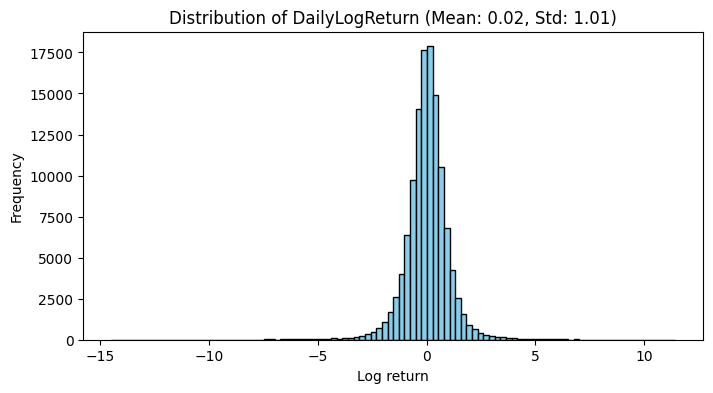

In [7]:
plt.figure(figsize=(8, 4))

column = "DailyLogReturn"
plt.hist(values[column], bins=100, color="skyblue", edgecolor="black")
plt.title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
plt.xlabel("Log return")
plt.ylabel("Frequency")
plt.show()

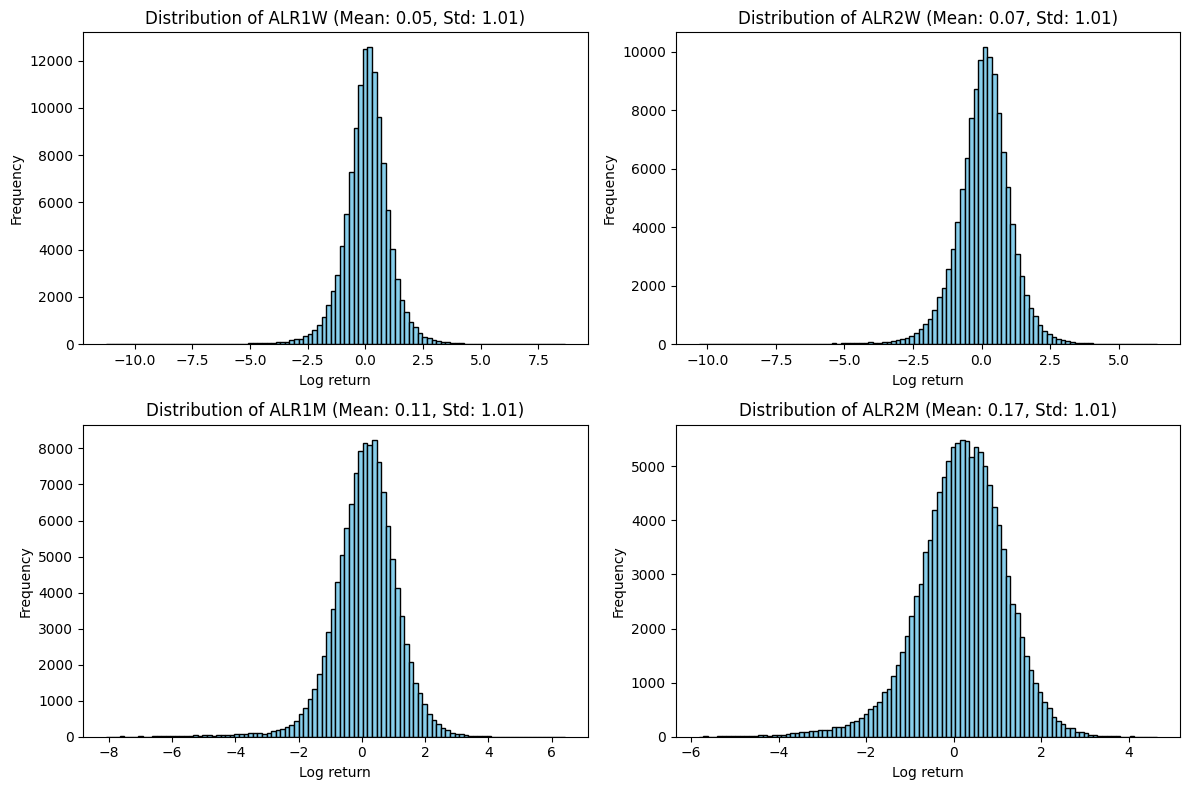

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for idx, column in enumerate(["ALR1W", "ALR2W", "ALR1M", "ALR2M"]):
	ax = axs[idx // 2, idx % 2]
	ax.hist(values[column], bins=100, color="skyblue", edgecolor="black")
	ax.set_title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
	ax.set_xlabel("Log return")
	ax.set_ylabel("Frequency")
	
plt.tight_layout()
plt.show()

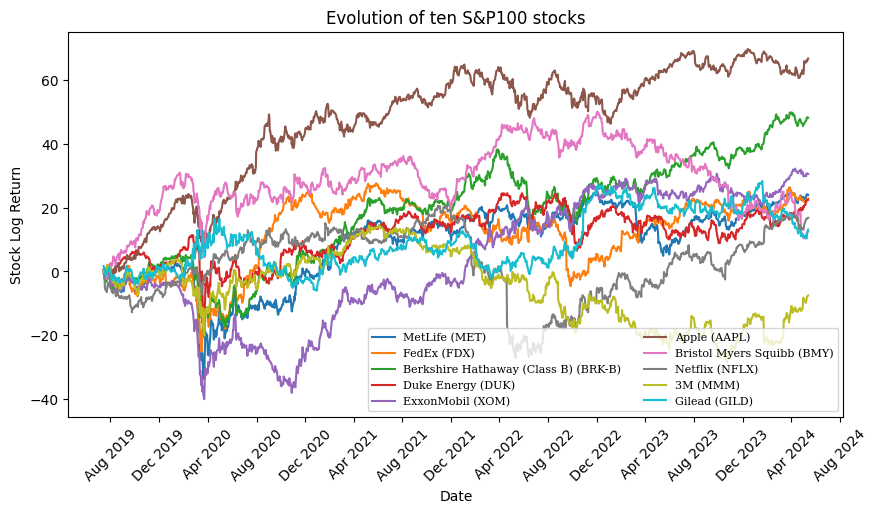

In [9]:
plt.figure(figsize=(10, 5))

for stock in np.random.choice(stocks.index, size=10, replace=False):
	plt.plot(values.loc[stock].index, np.cumsum(values.loc[stock]["DailyLogReturn"]), label=f'{stocks.loc[stock]["Name"]} ({stock})')
plt.title(f"Evolution of ten S&P100 stocks")
plt.xlabel('Date')
plt.gca().tick_params(axis='x', rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.ylabel('Stock Log Return')
plt.legend(ncol=2, loc="lower right", prop={'size': 8, 'family': 'serif'})
plt.show()

In [10]:
values.to_csv("../data/SP100/raw/values.csv")